# Multi-Scale Analysis End-to-End Test

End-to-end test for multi-scale analysis integrated with the full Delphi pipeline.

This runs a complete pipeline (cache -> construct -> explain -> score) and then
performs multi-scale analysis on the cached activations.

## Imports

In [1]:
import asyncio
import time
from pathlib import Path

import torch

from delphi.__main__ import run
from delphi.config import (
    CacheConfig,
    ConstructorConfig,
    MultiScaleConfig,
    RunConfig,
    SamplerConfig,
)
from delphi.utils import base_path_cfg_aware
from delphi.latents import LatentDataset
from delphi.latents.latents import ActivationData
from delphi.latents.loader import TensorBuffer
from delphi.latents.multi_scale_analysis import compare_scales, summarize_multi_scale
from delphi.latents.multi_scale_constructors import multi_scale_constructor
from delphi.log.result_analysis import get_agg_metrics, load_data

INFO 11-04 17:07:57 [__init__.py:216] Automatically detected platform cuda.


## Configuration

In [2]:
# Configure cache settings
cache_cfg = CacheConfig(
    dataset_repo="EleutherAI/fineweb-edu-dedup-10b",
    dataset_split="train[:5%]",
    dataset_column="text",
    batch_size=8,
    cache_ctx_len=512,  # Large enough to test multiple scales
    n_splits=5,
    n_tokens=2_500_000,
)

In [3]:
# Configure sampler
sampler_cfg = SamplerConfig(
    train_type="quantiles",
    test_type="quantiles",
    n_examples_train=40,
    n_examples_test=50,
    n_quantiles=10,
)

In [4]:
# Configure constructor
constructor_cfg = ConstructorConfig(
    min_examples=90,
    example_ctx_len=32,
    n_non_activating=50,
    non_activating_source="random",
    faiss_embedding_cache_enabled=True,
    faiss_embedding_cache_dir=".embedding_cache",
)

In [5]:
# Configure multi-scale analysis
multi_scale_cfg = MultiScaleConfig(
    # context_sizes=[16, 32, 64, 128],  # Must all divide cache_ctx_len=256
    n_examples_per_scale=50,
    min_examples=10,
    variance_threshold=0.1,
)

In [ ]:
# List of hookpoints to test - sampling across different layers
# pythia-160m has 12 layers (0-11)
hookpoints_to_test = [
    "layers.0.mlp",
    # "layers.2.mlp",
    "layers.4.mlp",
    # "layers.6.mlp",
    # "layers.8.mlp",
    # "layers.10.mlp",
    # "layers.11.mlp",  # Final layer
]

# We'll store results for each hookpoint
all_hookpoint_results = {}

## Run Pipeline Once With All Hookpoints

In [7]:
# Configure run with ALL hookpoints at once
run_cfg = RunConfig(
    name="test_multi_scale_all_hookpoints",
    overwrite=["cache", "scores"],
    model="EleutherAI/pythia-160m",
    sparse_model="EleutherAI/sae-pythia-160m-32k",
    hookpoints=hookpoints_to_test,  # Pass all hookpoints at once
    explainer_model="hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4",
    explainer_model_max_len=4208,
    max_latents=100,
    seed=22,
    num_gpus=torch.cuda.device_count(),
    filter_bos=True,
    verbose=False,
    sampler_cfg=sampler_cfg,
    constructor_cfg=constructor_cfg,
    cache_cfg=cache_cfg,
    multi_scale_cfg=multi_scale_cfg,
)

# Run the full pipeline once for all hookpoints
print("Running full Delphi pipeline with all hookpoints...")
print(f"Hookpoints: {hookpoints_to_test}\n")
start_time = time.time()
await run(run_cfg)
base_path = base_path_cfg_aware(run_cfg)
pipeline_time = time.time() - start_time
print(f"\nPipeline completed in {pipeline_time:.2f} seconds")

# Print memory stats
allocated = torch.cuda.memory_allocated() / 1e9
reserved = torch.cuda.memory_reserved() / 1e9
print(f"\nGPU Memory after pipeline:")
print(f"  Allocated: {allocated:.2f} GB")
print(f"  Reserved: {reserved:.2f} GB")

# Initialize results dictionary
all_hookpoint_results = {hp: {} for hp in hookpoints_to_test}

Running full Delphi pipeline with all hookpoints...
Hookpoints: ['layers.0.mlp', 'layers.2.mlp', 'layers.4.mlp', 'layers.6.mlp', 'layers.8.mlp', 'layers.10.mlp', 'layers.11.mlp']



`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 50 files:   0%|          | 0/50 [00:00<?, ?it/s]

Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}
Dropping extra args {'signed': False}


Resolving path for hookpoint: layers.0.mlp
Resolving path for hookpoint: layers.2.mlp
Resolving path for hookpoint: layers.4.mlp
Resolving path for hookpoint: layers.6.mlp
Resolving path for hookpoint: layers.8.mlp
Resolving path for hookpoint: layers.10.mlp
Resolving path for hookpoint: layers.11.mlp
Overwriting results from /root/delphi/tests/results/test_multi_scale_all_hookpoints/latents


Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Caching latents: 100%|██████████| 610/610 [00:49<00:00, 12.24it/s, Total Tokens=2,498,560]


Skipping neighbour creation
Overwriting results from /root/delphi/tests/results/test_multi_scale_all_hookpoints/scores
INFO 11-04 17:09:17 [utils.py:233] non-default args: {'max_model_len': 4208, 'enable_prefix_caching': True, 'disable_log_stats': True, 'model': 'hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4'}
INFO 11-04 17:09:18 [model.py:547] Resolved architecture: LlamaForCausalLM
INFO 11-04 17:09:18 [model.py:1510] Using max model len 4208
INFO 11-04 17:09:18 [awq_marlin.py:119] The model is convertible to awq_marlin during runtime. Using awq_marlin kernel.
INFO 11-04 17:09:18 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=16384.
WARNING 11-04 17:09:19 [__init__.py:3036] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 11-04 17:09:22 [__init__.py:216] Aut

Loading safetensors checkpoint shards:   0% Completed | 0/9 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  11% Completed | 1/9 [00:00<00:04,  1.85it/s]
Loading safetensors checkpoint shards:  22% Completed | 2/9 [00:01<00:04,  1.63it/s]
Loading safetensors checkpoint shards:  33% Completed | 3/9 [00:01<00:03,  1.58it/s]
Loading safetensors checkpoint shards:  44% Completed | 4/9 [00:02<00:03,  1.54it/s]
Loading safetensors checkpoint shards:  56% Completed | 5/9 [00:03<00:02,  1.53it/s]
Loading safetensors checkpoint shards:  67% Completed | 6/9 [00:03<00:01,  1.52it/s]
Loading safetensors checkpoint shards:  78% Completed | 7/9 [00:04<00:01,  1.51it/s]
Loading safetensors checkpoint shards:  89% Completed | 8/9 [00:05<00:00,  1.64it/s]
Loading safetensors checkpoint shards: 100% Completed | 9/9 [00:05<00:00,  1.95it/s]
Loading safetensors checkpoint shards: 100% Completed | 9/9 [00:05<00:00,  1.69it/s]
(EngineCore_DP0 pid=28773) 


(EngineCore_DP0 pid=28773) INFO 11-04 17:09:32 [default_loader.py:267] Loading weights took 5.39 seconds
(EngineCore_DP0 pid=28773) INFO 11-04 17:09:36 [gpu_model_runner.py:2653] Model loading took 37.0899 GiB and 9.556053 seconds
(EngineCore_DP0 pid=28773) INFO 11-04 17:09:47 [backends.py:548] Using cache directory: /root/.cache/vllm/torch_compile_cache/0bb9f9cc9a/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=28773) INFO 11-04 17:09:47 [backends.py:559] Dynamo bytecode transform time: 11.07 s
(EngineCore_DP0 pid=28773) INFO 11-04 17:09:51 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 3.350 s
(EngineCore_DP0 pid=28773) INFO 11-04 17:09:59 [monitor.py:34] torch.compile takes 11.07 s in total
(EngineCore_DP0 pid=28773) INFO 11-04 17:10:01 [gpu_worker.py:298] Available KV cache memory: 83.63 GiB
(EngineCore_DP0 pid=28773) INFO 11-04 17:10:01 [kv_cache_utils.py:1087] GPU KV cache size: 274,032 tokens
(EngineCore_DP0 pid=28773)

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:10<00:00,  6.24it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 67/67 [00:10<00:00,  6.41it/s]


(EngineCore_DP0 pid=28773) INFO 11-04 17:10:24 [gpu_model_runner.py:3480] Graph capturing finished in 22 secs, took 1.69 GiB
(EngineCore_DP0 pid=28773) INFO 11-04 17:10:24 [core.py:210] init engine (profile, create kv cache, warmup model) took 48.39 seconds
INFO 11-04 17:10:25 [llm.py:306] Supported_tasks: ['generate']


Processing items: 0it [00:00, ?it/s]Not enough examples to explain the latent: 44
Not enough examples to explain the latent: 16
Processing items: 2it [01:46, 44.70s/it] Not enough examples to explain the latent: 64
Processing items: 46it [05:18,  5.48s/it]Not enough examples to explain the latent: 32
Processing items: 68it [07:06,  5.12s/it]Not enough examples to explain the latent: 88
Processing items: 151it [12:29,  2.76s/it]Parsing selections failed: AssertionError()
Processing items: 156it [14:14,  6.18s/it]Not enough examples to explain the latent: 24
Processing items: 178it [16:01,  6.20s/it]Not enough examples to explain the latent: 46
Not enough examples to explain the latent: 73
Not enough examples to explain the latent: 62
Not enough examples to explain the latent: 83
Not enough examples to explain the latent: 27
Not enough examples to explain the latent: 44
Not enough examples to explain the latent: 43
Processing items: 195it [16:03,  2.76s/it]Not enough examples to explain 

ERROR 11-04 17:29:41 [core_client.py:564] Engine core proc EngineCore_DP0 died unexpectedly, shutting down client.


[rank0]:[W1104 17:29:41.545862396 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


CancelledError: 

## Multi-Scale Analysis for Each Hookpoint

In [12]:
base_path = base_path_cfg_aware(run_cfg)
# Initialize results dictionary
all_hookpoint_results = {hp: {} for hp in hookpoints_to_test}

In [15]:
# Now analyze multi-scale characteristics for each hookpoint
n_latents_to_analyze = 50  # Analyze more latents for better statistics

# Iterate through each hookpoint's data
for hookpoint in hookpoints_to_test:
    print(f"\n{'='*60}")
    print(f"Multi-scale analysis for hookpoint: {hookpoint}")
    print(f"{'='*60}\n")
    
    start_time = time.time()
    
    # Construct path to latents directory (parent of all hookpoint dirs)
    latents_dir = base_path / "latents"
    
    if not latents_dir.exists():
        print(f"Warning: Path {latents_dir} does not exist, skipping...")
        all_hookpoint_results[hookpoint]["multi_scale_results"] = []
        all_hookpoint_results[hookpoint]["multi_scale_time"] = 0
        continue
    
    # Use LatentDataset to properly load cached data
    # Pass the parent latents directory and specify the module to filter
    dataset = LatentDataset(
        raw_dir=latents_dir,
        sampler_cfg=sampler_cfg,
        constructor_cfg=constructor_cfg,
        modules=[hookpoint],  # Filter to just this hookpoint
    )
    
    # Load tokens
    tokens = dataset.load_tokens()
    print(f"Loaded tokens: shape {tokens.shape}")
    
    # Analyze latents from the dataset
    multi_scale_results = []
    
    for i, buffer in enumerate(dataset.buffers):
        if len(multi_scale_results) >= n_latents_to_analyze:
            break
        
        # Load activations from this buffer
        latents, split_locations, split_activations = buffer.load_data_per_latent()
        
        for latent_idx, locations, activations in zip(latents, split_locations, split_activations):
            if len(multi_scale_results) >= n_latents_to_analyze:
                break
            
            # Create ActivationData
            activation_data = ActivationData(locations, activations)
            
            # Check if enough activations
            if len(activation_data.activations) < multi_scale_cfg.min_examples:
                continue
            
            # Run multi-scale constructor
            multi_scale_data = multi_scale_constructor(
                activation_data=activation_data,
                tokens=tokens,
                context_sizes=multi_scale_cfg.context_sizes,
                cache_ctx_len=cache_cfg.cache_ctx_len,
                n_examples_per_scale=multi_scale_cfg.n_examples_per_scale,
                min_examples=multi_scale_cfg.min_examples,
            )
            
            # Check if we got examples at multiple scales
            non_empty_scales = [
                ctx for ctx in multi_scale_cfg.context_sizes if multi_scale_data[ctx]
            ]
            
            if len(non_empty_scales) >= 2:
                # Run comparison
                comparison = compare_scales(multi_scale_data)
                summary = summarize_multi_scale(multi_scale_data)
                
                multi_scale_results.append(
                    {
                        "latent_idx": int(latent_idx),
                        "scale_type": summary["scale_type"],
                        "dominant_scale": summary["dominant_scale"],
                        "activation_variance": summary["activation_variance"],
                        "max_growth_ratio": summary["max_growth_ratio"],
                        "max_correlation": summary["max_correlation"],
                    }
                )
    
    multi_scale_time = time.time() - start_time
    print(f"Multi-scale analysis completed in {multi_scale_time:.2f} seconds")
    print(f"Analyzed {len(multi_scale_results)} latents")
    
    # Store results
    all_hookpoint_results[hookpoint]["multi_scale_results"] = multi_scale_results
    all_hookpoint_results[hookpoint]["multi_scale_time"] = multi_scale_time

    # Free GPU memory before next hookpoint analysis
    import gc
    del dataset, tokens
    if 'multi_scale_data' in locals():
        del multi_scale_data
    gc.collect()
    torch.cuda.empty_cache()


Multi-scale analysis for hookpoint: layers.0.mlp

Loaded tokens: shape torch.Size([4880, 512])
Multi-scale analysis completed in 1.55 seconds
Analyzed 50 latents

Multi-scale analysis for hookpoint: layers.2.mlp

Loaded tokens: shape torch.Size([4880, 512])
Multi-scale analysis completed in 1.43 seconds
Analyzed 50 latents

Multi-scale analysis for hookpoint: layers.4.mlp

Loaded tokens: shape torch.Size([4880, 512])
Multi-scale analysis completed in 1.44 seconds
Analyzed 50 latents

Multi-scale analysis for hookpoint: layers.6.mlp

Loaded tokens: shape torch.Size([4880, 512])
Multi-scale analysis completed in 1.40 seconds
Analyzed 50 latents

Multi-scale analysis for hookpoint: layers.8.mlp

Loaded tokens: shape torch.Size([4880, 512])
Multi-scale analysis completed in 1.36 seconds
Analyzed 50 latents

Multi-scale analysis for hookpoint: layers.10.mlp

Loaded tokens: shape torch.Size([4880, 512])
Multi-scale analysis completed in 1.47 seconds
Analyzed 50 latents

Multi-scale analysis

## Compare Hookpoints by Scale Type Distribution

In [16]:
# Analyze which hookpoints are better at detecting longer-scale features
import pandas as pd
from collections import Counter

# Scale type hierarchy: token < phrase < sentence < paragraph
scale_hierarchy = {
    "token": 1,
    "phrase": 2,
    "sentence": 3,
    "paragraph": 4,
    "unknown": 0,
}

# Collect statistics for each hookpoint
hookpoint_stats = []

for hookpoint, result_data in all_hookpoint_results.items():
    multi_scale_results = result_data["multi_scale_results"]
    
    if not multi_scale_results:
        print(f"Warning: No multi-scale results for {hookpoint}")
        continue
    
    # Count scale types
    scale_types = [r["scale_type"] for r in multi_scale_results]
    scale_counter = Counter(scale_types)
    
    # Calculate statistics
    dominant_scales = [r["dominant_scale"] for r in multi_scale_results]
    avg_dominant_scale = sum(dominant_scales) / len(dominant_scales)
    
    # Calculate proportion of longer features (sentence or paragraph)
    long_features = sum(1 for st in scale_types if st in ["sentence", "paragraph"])
    long_features_pct = 100 * long_features / len(scale_types)
    
    # Calculate average scale hierarchy score
    avg_scale_score = sum(scale_hierarchy[st] for st in scale_types) / len(scale_types)
    
    # Calculate other metrics
    avg_variance = sum(r["activation_variance"] for r in multi_scale_results) / len(multi_scale_results)
    avg_growth_ratio = sum(r["max_growth_ratio"] for r in multi_scale_results) / len(multi_scale_results)
    avg_correlation = sum(r["max_correlation"] for r in multi_scale_results) / len(multi_scale_results)
    
    hookpoint_stats.append({
        "hookpoint": hookpoint,
        "n_latents": len(multi_scale_results),
        "avg_dominant_scale": avg_dominant_scale,
        "long_features_pct": long_features_pct,
        "avg_scale_score": avg_scale_score,
        "token_count": scale_counter.get("token", 0),
        "phrase_count": scale_counter.get("phrase", 0),
        "sentence_count": scale_counter.get("sentence", 0),
        "paragraph_count": scale_counter.get("paragraph", 0),
        "unknown_count": scale_counter.get("unknown", 0),
        "avg_activation_variance": avg_variance,
        "avg_growth_ratio": avg_growth_ratio,
        "avg_correlation": avg_correlation,
    })

# Create DataFrame for easier analysis
stats_df = pd.DataFrame(hookpoint_stats)
stats_df = stats_df.sort_values("long_features_pct", ascending=False)

print("\n" + "="*80)
print("HOOKPOINT COMPARISON: BETTER FOR LONGER FEATURES")
print("="*80)
print("\nRanked by percentage of sentence/paragraph features:\n")
print(stats_df[["hookpoint", "n_latents", "long_features_pct", "avg_dominant_scale", "avg_scale_score"]].to_string(index=False))

print("\n" + "="*80)
print("DETAILED SCALE TYPE DISTRIBUTION")
print("="*80 + "\n")
print(stats_df[["hookpoint", "token_count", "phrase_count", "sentence_count", "paragraph_count", "unknown_count"]].to_string(index=False))

print("\n" + "="*80)
print("ADDITIONAL METRICS")
print("="*80 + "\n")
print(stats_df[["hookpoint", "avg_activation_variance", "avg_growth_ratio", "avg_correlation"]].to_string(index=False))


HOOKPOINT COMPARISON: BETTER FOR LONGER FEATURES

Ranked by percentage of sentence/paragraph features:

    hookpoint  n_latents  long_features_pct  avg_dominant_scale  avg_scale_score
layers.10.mlp         50               10.0                 8.0             1.22
 layers.0.mlp         50                6.0                 8.0             1.22
layers.11.mlp         50                4.0                 8.0             1.10
 layers.4.mlp         50                0.0                 8.0             1.00
 layers.2.mlp         50                0.0                 8.0             1.00
 layers.8.mlp         50                0.0                 8.0             1.00
 layers.6.mlp         50                0.0                 8.0             1.00

DETAILED SCALE TYPE DISTRIBUTION

    hookpoint  token_count  phrase_count  sentence_count  paragraph_count  unknown_count
layers.10.mlp           44             1               5                0              0
 layers.0.mlp           42        

## Visualize Results Across Hookpoints

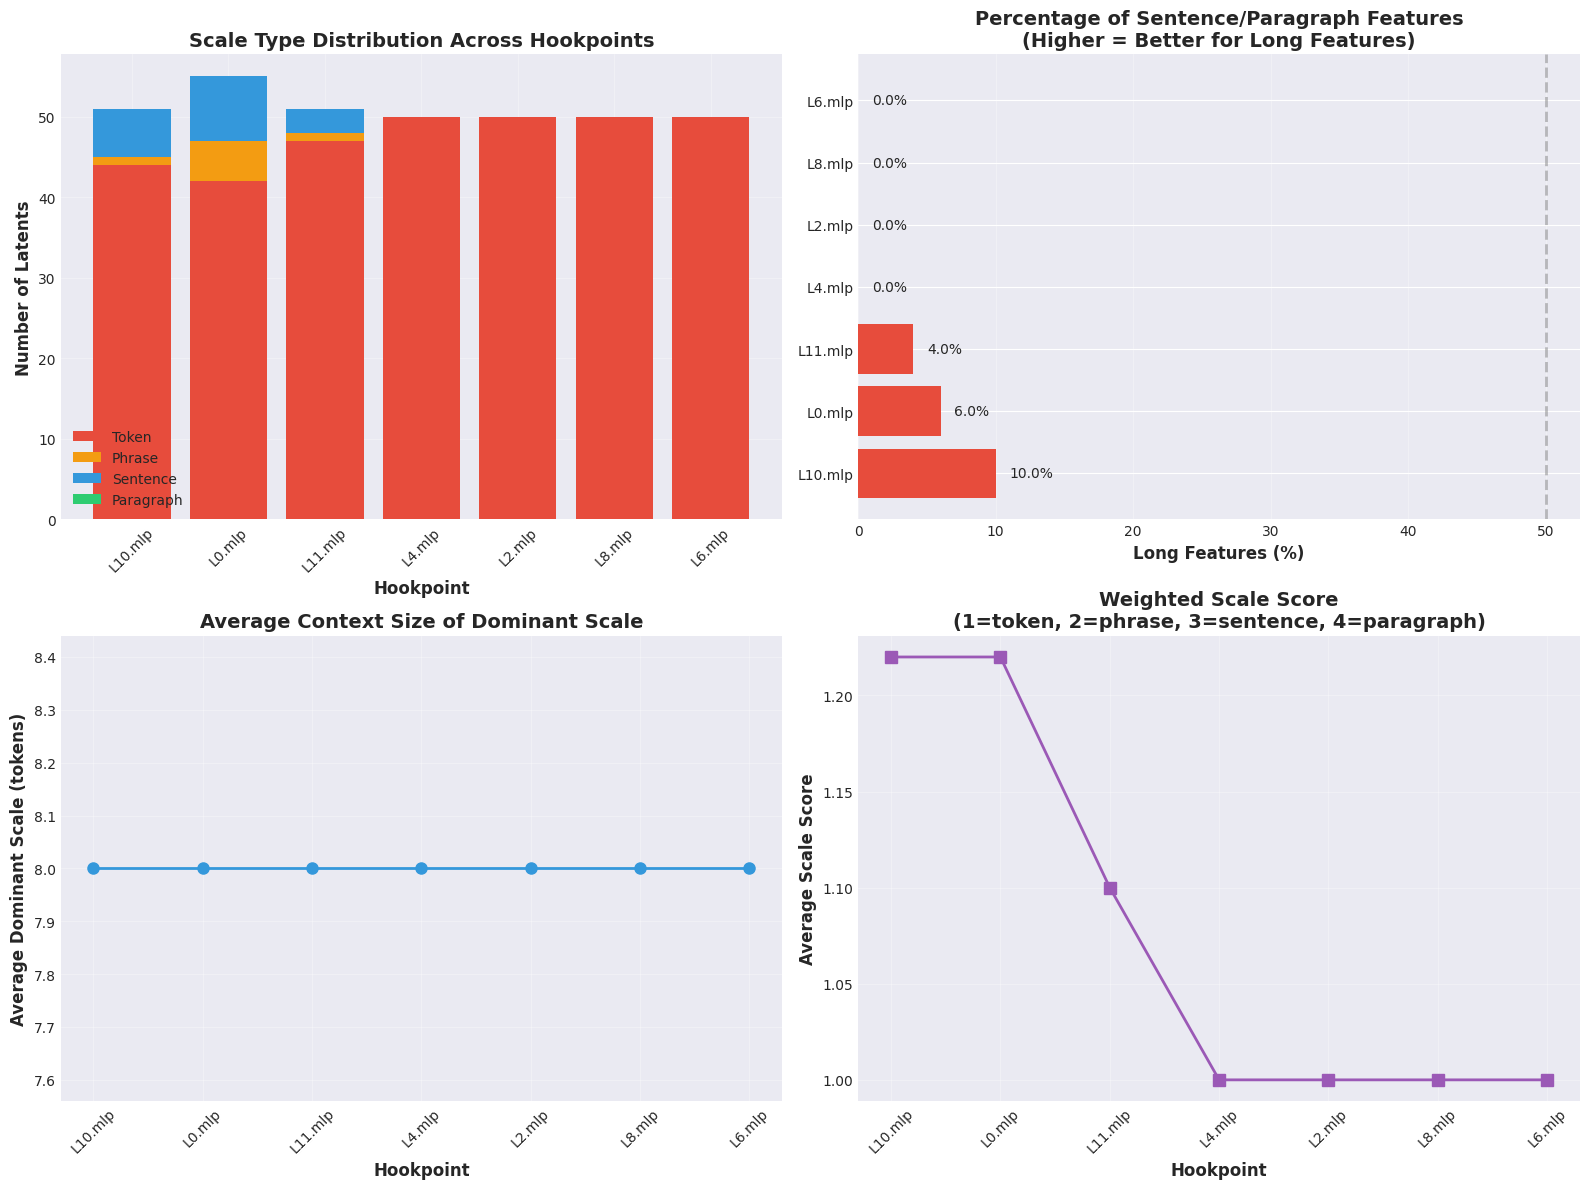


Visualization saved as 'hookpoint_scale_analysis.png'


In [18]:
# Create visualizations
import matplotlib.pyplot as plt
import numpy as np

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Stacked bar chart of scale type distribution
ax1 = axes[0, 0]
hookpoints_ordered = stats_df["hookpoint"].values
x_pos = np.arange(len(hookpoints_ordered))

token_counts = stats_df["token_count"].values
phrase_counts = stats_df["phrase_count"].values
sentence_counts = stats_df["sentence_count"].values
paragraph_counts = stats_df["paragraph_count"].values

ax1.bar(x_pos, token_counts, label='Token', color='#e74c3c')
ax1.bar(x_pos, phrase_counts, bottom=token_counts, label='Phrase', color='#f39c12')
ax1.bar(x_pos, phrase_counts + sentence_counts, bottom=token_counts + phrase_counts, 
        label='Sentence', color='#3498db')
ax1.bar(x_pos, paragraph_counts, 
        bottom=token_counts + phrase_counts + sentence_counts,
        label='Paragraph', color='#2ecc71')

ax1.set_xlabel('Hookpoint', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Latents', fontsize=12, fontweight='bold')
ax1.set_title('Scale Type Distribution Across Hookpoints', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([h.replace('layers.', 'L') for h in hookpoints_ordered], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Percentage of long features (sentence + paragraph)
ax2 = axes[0, 1]
colors = ['#2ecc71' if pct > 50 else '#e74c3c' for pct in stats_df["long_features_pct"]]
bars = ax2.barh(range(len(hookpoints_ordered)), stats_df["long_features_pct"].values, color=colors)
ax2.set_yticks(range(len(hookpoints_ordered)))
ax2.set_yticklabels([h.replace('layers.', 'L') for h in hookpoints_ordered])
ax2.set_xlabel('Long Features (%)', fontsize=12, fontweight='bold')
ax2.set_title('Percentage of Sentence/Paragraph Features\n(Higher = Better for Long Features)', 
              fontsize=14, fontweight='bold')
ax2.axvline(x=50, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax2.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, stats_df["long_features_pct"].values)):
    ax2.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=10)

# Plot 3: Average dominant scale
ax3 = axes[1, 0]
ax3.plot(range(len(hookpoints_ordered)), stats_df["avg_dominant_scale"].values, 
         marker='o', linewidth=2, markersize=8, color='#3498db')
ax3.set_xticks(range(len(hookpoints_ordered)))
ax3.set_xticklabels([h.replace('layers.', 'L') for h in hookpoints_ordered], rotation=45)
ax3.set_xlabel('Hookpoint', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Dominant Scale (tokens)', fontsize=12, fontweight='bold')
ax3.set_title('Average Context Size of Dominant Scale', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Average scale score (weighted by hierarchy)
ax4 = axes[1, 1]
ax4.plot(range(len(hookpoints_ordered)), stats_df["avg_scale_score"].values,
         marker='s', linewidth=2, markersize=8, color='#9b59b6')
ax4.set_xticks(range(len(hookpoints_ordered)))
ax4.set_xticklabels([h.replace('layers.', 'L') for h in hookpoints_ordered], rotation=45)
ax4.set_xlabel('Hookpoint', fontsize=12, fontweight='bold')
ax4.set_ylabel('Average Scale Score', fontsize=12, fontweight='bold')
ax4.set_title('Weighted Scale Score\n(1=token, 2=phrase, 3=sentence, 4=paragraph)', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hookpoint_scale_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'hookpoint_scale_analysis.png'")

## Summary: Best Hookpoints for Long Features

In [19]:
# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY: BEST HOOKPOINTS FOR LONG FEATURES")
print("="*80 + "\n")

# Top 3 hookpoints by long features percentage
top_3 = stats_df.head(3)

print("TOP 3 HOOKPOINTS (by % of sentence/paragraph features):\n")
for idx, row in top_3.iterrows():
    layer_num = row["hookpoint"].split('.')[1]
    print(f"{row['hookpoint']}:")
    print(f"  - Long features: {row['long_features_pct']:.1f}%")
    print(f"  - Avg dominant scale: {row['avg_dominant_scale']:.1f} tokens")
    print(f"  - Scale score: {row['avg_scale_score']:.2f}")
    print(f"  - Distribution: {row['sentence_count']} sentence, {row['paragraph_count']} paragraph, " +
          f"{row['phrase_count']} phrase, {row['token_count']} token")
    print()

# Layer analysis
early_layers = stats_df[stats_df["hookpoint"].str.contains("layers\.[0-3]\.")]
middle_layers = stats_df[stats_df["hookpoint"].str.contains("layers\.[4-7]\.")]
late_layers = stats_df[stats_df["hookpoint"].str.contains("layers\.[8-9]\.") | 
                        stats_df["hookpoint"].str.contains("layers\.1[0-1]\.")]

if len(early_layers) > 0 and len(middle_layers) > 0 and len(late_layers) > 0:
    print("\n" + "-"*80)
    print("LAYER DEPTH ANALYSIS:")
    print("-"*80 + "\n")
    print(f"Early layers (0-3): avg long features = {early_layers['long_features_pct'].mean():.1f}%")
    print(f"Middle layers (4-7): avg long features = {middle_layers['long_features_pct'].mean():.1f}%")
    print(f"Late layers (8-11): avg long features = {late_layers['long_features_pct'].mean():.1f}%")
    print()

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80 + "\n")

best_hookpoint = stats_df.iloc[0]
worst_hookpoint = stats_df.iloc[-1]

print(f"✓ BEST: {best_hookpoint['hookpoint']} has {best_hookpoint['long_features_pct']:.1f}% long features")
print(f"✗ WORST: {worst_hookpoint['hookpoint']} has {worst_hookpoint['long_features_pct']:.1f}% long features")
print(f"📊 DIFFERENCE: {best_hookpoint['long_features_pct'] - worst_hookpoint['long_features_pct']:.1f} percentage points")

# Correlation insights
high_variance_hp = stats_df.nlargest(1, "avg_activation_variance").iloc[0]
high_growth_hp = stats_df.nlargest(1, "avg_growth_ratio").iloc[0]

print(f"\n🔥 HIGHEST activation variance: {high_variance_hp['hookpoint']} ({high_variance_hp['avg_activation_variance']:.4f})")
print(f"📈 HIGHEST growth ratio: {high_growth_hp['hookpoint']} ({high_growth_hp['avg_growth_ratio']:.4f})")

print("\n" + "="*80)


FINAL SUMMARY: BEST HOOKPOINTS FOR LONG FEATURES

TOP 3 HOOKPOINTS (by % of sentence/paragraph features):

layers.10.mlp:
  - Long features: 10.0%
  - Avg dominant scale: 8.0 tokens
  - Scale score: 1.22
  - Distribution: 5 sentence, 0 paragraph, 1 phrase, 44 token

layers.0.mlp:
  - Long features: 6.0%
  - Avg dominant scale: 8.0 tokens
  - Scale score: 1.22
  - Distribution: 3 sentence, 0 paragraph, 5 phrase, 42 token

layers.11.mlp:
  - Long features: 4.0%
  - Avg dominant scale: 8.0 tokens
  - Scale score: 1.10
  - Distribution: 2 sentence, 0 paragraph, 1 phrase, 47 token


--------------------------------------------------------------------------------
LAYER DEPTH ANALYSIS:
--------------------------------------------------------------------------------

Early layers (0-3): avg long features = 3.0%
Middle layers (4-7): avg long features = 0.0%
Late layers (8-11): avg long features = 4.7%


KEY INSIGHTS:

✓ BEST: layers.10.mlp has 10.0% long features
✗ WORST: layers.6.mlp has 0.0%

## Validation: Basic Checks

In [20]:
# Basic validation checks
print("\n" + "="*80)
print("VALIDATION CHECKS")
print("="*80 + "\n")

# Check that all hookpoints were analyzed
assert len(all_hookpoint_results) == len(hookpoints_to_test), \
    f"Expected {len(hookpoints_to_test)} hookpoints, got {len(all_hookpoint_results)}"
print(f"✓ All {len(hookpoints_to_test)} hookpoints were successfully analyzed")

# Check that we got results for all hookpoints
hookpoints_with_results = sum(1 for hp, data in all_hookpoint_results.items() 
                               if len(data.get("multi_scale_results", [])) > 0)
print(f"✓ {hookpoints_with_results}/{len(hookpoints_to_test)} hookpoints have multi-scale results")

# Verify DataFrame was created correctly
assert len(stats_df) > 0, "Statistics DataFrame is empty"
print(f"✓ Statistics DataFrame created with {len(stats_df)} rows")

# Verify all expected columns exist
expected_columns = [
    "hookpoint", "n_latents", "avg_dominant_scale", "long_features_pct", 
    "avg_scale_score", "token_count", "phrase_count", "sentence_count", 
    "paragraph_count", "unknown_count"
]
for col in expected_columns:
    assert col in stats_df.columns, f"Missing column: {col}"
print(f"✓ All expected columns present in statistics")

print("\n" + "="*80)
print("✅ ALL VALIDATION CHECKS PASSED!")
print("="*80)

# Calculate total time
total_analysis_time = sum(data["multi_scale_time"] for data in all_hookpoint_results.values())
print(f"\nPipeline time: {pipeline_time:.2f} seconds")
print(f"Total analysis time: {total_analysis_time:.2f} seconds")
print(f"Grand total: {pipeline_time + total_analysis_time:.2f} seconds")


VALIDATION CHECKS

✓ All 7 hookpoints were successfully analyzed
✓ 7/7 hookpoints have multi-scale results
✓ Statistics DataFrame created with 7 rows
✓ All expected columns present in statistics

✅ ALL VALIDATION CHECKS PASSED!


NameError: name 'pipeline_time' is not defined